# Validity of using prescription records to identify patient comorbidities
## COPD in 1 year follow-up

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|Jenni Quint|
|drug codes|Jenni Quint (excluding antibiotics)|
|sql date|23.06.2025|
|sql code|copdselection_20250623.sql| 

In [1]:
    clear all

### Import from SQL server and data wrangling

In [2]:
odbc load, exec("select * from [copd_425000_1yFU_20250619]") dsn("sqlserverconnect")

In [ ]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab

egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab


replace bnf_code = "Adrenoreceptor agonist" if bnf_code== "030101"
replace bnf_code = "Antimuscarinic Bronchodilator" if bnf_code== "030102"
replace bnf_code = "Theophylline" if bnf_code== "030103"
replace bnf_code = "Compound bronchodilator" if bnf_code== "030104"
replace bnf_code = "Devices" if bnf_code== "030105" | bnf_code=="210102" | bnf_code=="211200"
replace bnf_code = "Corticosteroids" if bnf_code== "030200"
replace bnf_code = "OCT" if bnf_code== "060302"
replace bnf_code = "Topical nasal decongestance" if bnf_code== "120202"
replace bnf_code = "Other/unknown" if missing(bnf_code) & ! missing(drug_dt)




replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"


encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(51,821 missing values generated)
(51,821 real changes made)
(11,053 missing values generated)
(11,053 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str22
(24,685 real changes made)
variable bnf_code was str22 now str29
(2,890 real changes made)
(203 real changes made)
(739 real changes made)
(0 real changes made)
(15,004 real changes made)
(0 real changes made)
(356 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


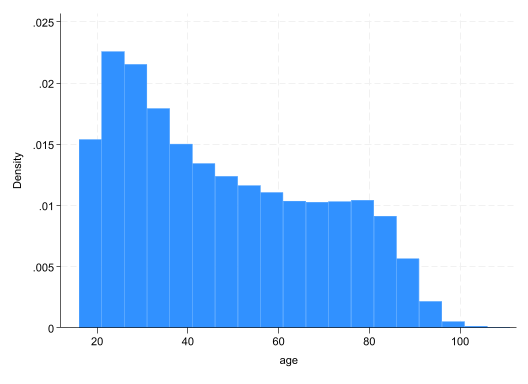

In [4]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [5]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +-----------------------------------------------------------------------------------------------------+
  |                                                               description   Freq.   Percent     %<= |
  |-----------------------------------------------------------------------------------------------------|
  |                       chronic obstructive pulmonary disease annual review    1725     15.61   15.61 |
  |                       Chronic obstructive pulmonary disease annual review    1638     14.82   30.43 |
  |                     other specified chronic obstructive pulmonary disease    1226     11.09   41.52 |
  |                                               chr. airway obstruction nos    1053      9.53   51.04 |
  |               chronic obstructive pulmonary disease monitoring 1st letter     682      6.17   57.22 |
  |-----------------------------------------------------------------------------------------------------|
  |               Chronic obstructive pulmona

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [6]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +----------------------------------------------------------+
  |                      bnf_code   Freq.   Percent      %<= |
  |----------------------------------------------------------|
  |        Adrenoreceptor agonist   24685     47.64    47.64 |
  |               Corticosteroids   15004     28.95    76.59 |
  |                        060302    7942     15.33    91.91 |
  | Antimuscarinic Bronchodilator    2890      5.58    97.49 |
  |       Compound bronchodilator     739      1.43    98.92 |
  |----------------------------------------------------------|
  |                 Other/unknown     356      0.69    99.60 |
  |                  Theophylline     203      0.39   100.00 |
  +----------------------------------------------------------+


### Results
#### Overall

In [7]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    10,195        858 |    11,053 
    Normal |    41,626    372,321 |   413,947 
-----------+----------------------+----------
     Total |    51,821    373,179 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.6%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.2%     91.7%     92.7%
Specificity                      Pr(-|N)     89.9%     89.9%     90.0%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.17      9.

#### Males

In [8]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,526        508 |     6,034 
    Normal |    17,297    184,954 |   202,251 
-----------+----------------------+----------
     Total |    22,823    185,462 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.9%      2.8%       3.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.6%     90.9%     92.3%
Specificity                      Pr(-|N)     91.4%     91.3%     91.6%
ROC area               (Sens. + Spec.)/2      0.92      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.71     10.

#### Females

In [9]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,669        350 |     5,019 
    Normal |    24,328    187,359 |   211,687 
-----------+----------------------+----------
     Total |    28,997    187,709 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.3%      2.3%       2.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     92.3%     93.7%
Specificity                      Pr(-|N)     88.5%     88.4%     88.6%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.09      7.

#### Age
*16-29*

In [10]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |        20         17 |        37 
    Normal |     8,004    109,633 |   117,637 
-----------+----------------------+----------
     Total |     8,024    109,650 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.0%      0.0%       0.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     54.1%     36.9%     70.5%
Specificity                      Pr(-|N)     93.2%     93.1%     93.3%
ROC area               (Sens. + Spec.)/2      0.74      0.65      0.82 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.94      5.

*30-69*

In [11]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,297        351 |     4,648 
    Normal |    21,657    195,090 |   216,747 
-----------+----------------------+----------
     Total |    25,954    195,441 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.1%      2.0%       2.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.4%     91.7%     93.2%
Specificity                      Pr(-|N)     90.0%     89.9%     90.1%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.25      9.

In [12]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,878        490 |     6,368 
    Normal |    11,965     67,598 |    79,563 
-----------+----------------------+----------
     Total |    17,843     68,088 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.4%      7.2%       7.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.3%     91.6%     92.9%
Specificity                      Pr(-|N)     85.0%     84.7%     85.2%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.14      6.

#### Year at start of oberservation period 
*2004-2009*

In [13]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,553        303 |     3,856 
    Normal |    15,714    130,430 |   146,144 
-----------+----------------------+----------
     Total |    19,267    130,733 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.1%     91.2%     93.0%
Specificity                      Pr(-|N)     89.2%     89.1%     89.4%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.57      8.

*2010-2015*

In [14]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,781        316 |     4,097 
    Normal |    14,489    131,414 |   145,903 
-----------+----------------------+----------
     Total |    18,270    131,730 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.6%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.3%     91.4%     93.1%
Specificity                      Pr(-|N)     90.1%     89.9%     90.2%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.29      9.

*2016-2020*

In [15]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,861        239 |     3,100 
    Normal |    11,423    110,477 |   121,900 
-----------+----------------------+----------
     Total |    14,284    110,716 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.4%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.3%     91.3%     93.2%
Specificity                      Pr(-|N)     90.6%     90.5%     90.8%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.85      9.

#### IMD of practice
*1-3*

In [16]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,052        330 |     4,382 
    Normal |    14,475    135,694 |   150,169 
-----------+----------------------+----------
     Total |    18,527    136,024 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.8%       2.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.5%     91.6%     93.2%
Specificity                      Pr(-|N)     90.4%     90.2%     90.5%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.59      9.

*4-7*

In [17]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,522        263 |     3,785 
    Normal |    14,946    124,314 |   139,260 
-----------+----------------------+----------
     Total |    18,468    124,577 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.6%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.1%     92.2%     93.8%
Specificity                      Pr(-|N)     89.3%     89.1%     89.4%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.67      8.

*8-10*

In [18]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,600        264 |     2,864 
    Normal |    12,080    109,871 |   121,951 
-----------+----------------------+----------
     Total |    14,680    110,135 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.3%      2.2%       2.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     90.8%     89.7%     91.8%
Specificity                      Pr(-|N)     90.1%     89.9%     90.3%
ROC area               (Sens. + Spec.)/2      0.90      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.16      8.

#### Commissioning Regions
EAST OF ENGLAND

In [19]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,141        161 |     2,302 
    Normal |     9,990     77,345 |    87,335 
-----------+----------------------+----------
     Total |    12,131     77,506 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     91.9%     94.0%
Specificity                      Pr(-|N)     88.6%     88.3%     88.8%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.13      7.

London

In [20]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       176         26 |       202 
    Normal |     1,138     15,385 |    16,523 
-----------+----------------------+----------
     Total |     1,314     15,411 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.2%      1.0%       1.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.1%     81.7%     91.4%
Specificity                      Pr(-|N)     93.1%     92.7%     93.5%
ROC area               (Sens. + Spec.)/2      0.90      0.88      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     12.65     11.

Midlands

In [21]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,373        104 |     1,477 
    Normal |     5,268     39,798 |    45,066 
-----------+----------------------+----------
     Total |     6,641     39,902 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.2%      3.0%       3.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     91.5%     94.2%
Specificity                      Pr(-|N)     88.3%     88.0%     88.6%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.95      7.

Yorkshire

In [22]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,335        193 |     2,528 
    Normal |     7,999     75,584 |    83,583 
-----------+----------------------+----------
     Total |    10,334     75,777 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.9%      2.8%       3.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.4%     91.3%     93.4%
Specificity                      Pr(-|N)     90.4%     90.2%     90.6%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.65      9.

North West

In [23]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,200         79 |     1,279 
    Normal |     4,264     42,050 |    46,314 
-----------+----------------------+----------
     Total |     5,464     42,129 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.5%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.8%     92.4%     95.1%
Specificity                      Pr(-|N)     90.8%     90.5%     91.1%
ROC area               (Sens. + Spec.)/2      0.92      0.92      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.19      9.

South East

In [24]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,747        188 |     1,935 
    Normal |     7,973     80,577 |    88,550 
-----------+----------------------+----------
     Total |     9,720     80,765 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.1%      2.0%       2.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     90.3%     88.9%     91.6%
Specificity                      Pr(-|N)     91.0%     90.8%     91.2%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.03      9.

South West

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,001         85 |     1,086 
    Normal |     3,846     31,244 |    35,090 
-----------+----------------------+----------
     Total |     4,847     31,329 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.0%      2.8%       3.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.2%     90.4%     93.7%
Specificity                      Pr(-|N)     89.0%     88.7%     89.4%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.41      8.

#### System
SystmOne

In [26]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,019        455 |     6,474 
    Normal |    23,828    198,453 |   222,281 
-----------+----------------------+----------
     Total |    29,847    198,908 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.8%       2.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     92.3%     93.6%
Specificity                      Pr(-|N)     89.3%     89.2%     89.4%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.67      8.

Vision

In [27]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       281         24 |       305 
    Normal |     1,387     12,052 |    13,439 
-----------+----------------------+----------
     Total |     1,668     12,076 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.2%      2.0%       2.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.1%     88.5%     94.9%
Specificity                      Pr(-|N)     89.7%     89.2%     90.2%
ROC area               (Sens. + Spec.)/2      0.91      0.89      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.93      8.

EMIS

In [28]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,884        378 |     4,262 
    Normal |    16,364    161,739 |   178,103 
-----------+----------------------+----------
     Total |    20,248    162,117 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.3%      2.3%       2.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.1%     90.2%     92.0%
Specificity                      Pr(-|N)     90.8%     90.7%     90.9%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.92      9.

#### RA_Index
Index==1

In [29]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,730        669 |     8,399 
    Normal |    30,415    282,883 |   313,298 
-----------+----------------------+----------
     Total |    38,145    283,552 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.6%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     91.4%     92.6%
Specificity                      Pr(-|N)     90.3%     90.2%     90.4%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.48      9.

Index==0

In [30]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,465        189 |     2,654 
    Normal |    11,211     89,438 |   100,649 
-----------+----------------------+----------
     Total |    13,676     89,627 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.9%     91.8%     93.8%
Specificity                      Pr(-|N)     88.9%     88.7%     89.1%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.34      8.

#### Ethnicity
Ethnicity==0000white

In [31]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,110        652 |     8,762 
    Normal |    29,108    220,111 |   249,219 
-----------+----------------------+----------
     Total |    37,218    220,763 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.4%      3.3%       3.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.6%     92.0%     93.1%
Specificity                      Pr(-|N)     88.3%     88.2%     88.4%
ROC area               (Sens. + Spec.)/2      0.90      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.92      7.

In [32]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       245         47 |       292 
    Normal |     3,264     40,312 |    43,576 
-----------+----------------------+----------
     Total |     3,509     40,359 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     83.9%     79.2%     87.9%
Specificity                      Pr(-|N)     92.5%     92.3%     92.8%
ROC area               (Sens. + Spec.)/2      0.88      0.86      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.20     10.

In [33]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,840        159 |     1,999 
    Normal |     9,254    111,898 |   121,152 
-----------+----------------------+----------
     Total |    11,094    112,057 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.6%       1.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     90.8%     93.2%
Specificity                      Pr(-|N)     92.4%     92.2%     92.5%
ROC area               (Sens. + Spec.)/2      0.92      0.92      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     12.05     11.

In [34]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [35]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [36]:
logistic diag_pos if test==1


Logistic regression                                    Number of obs =  51,674
                                                       LR chi2(0)    =   -0.00
                                                       Prob > chi2   =       .
Log likelihood = -25633.309                            Pseudo R2     = -0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   .2451566   .0027121  -127.08   0.000     .2398982    .2505303
------------------------------------------------------------------------------


In [37]:
logistic diag_pos i.bnf_code_values if test==1

note: 2.bnf_code_values != 0 predicts failure perfectly;
      2.bnf_code_values omitted and 2 obs not used.


Logistic regression                                    Number of obs =  51,672
                                                       LR chi2(6)    = 4665.64
                                                       Prob > chi2   =  0.0000
Log likelihood = -23300.051                            Pseudo R2     =  0.0910

------------------------------------------------------------------------------------------------
                      diag_pos | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------------------------+----------------------------------------------------------------
               bnf_code_values |
                       100103  |          1  (empty)
       Adrenoreceptor agonist  |   1.610677     .06477    11.85   0.000     1.488604    1.742761
Antimuscarinic Bronchodilator  |   18.73678   1.017037    53.99   0.000      16.8458    20.84003
 

In [38]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -23005.102  
Iteration 1:  Log likelihood = -22383.923  
Iteration 2:  Log likelihood = -22294.912  
Iteration 3:  Log likelihood = -22287.339  
Iteration 4:  Log likelihood = -22287.234  
Iteration 5:  Log likelihood = -22287.234  

Refining starting values:

Grid node 0:  Log likelihood = -22340.706

Fitting full model:

Iteration 0:  Log likelihood = -22340.706  (not concave)
Iteration 1:  Log likelihood = -22270.794  (not concave)
Iteration 2:  Log likelihood = -22202.966  (not concave)
Iteration 3:  Log likelihood =  -22180.63  
Iteration 4:  Log likelihood =  -22177.69  
Iteration 5:  Log likelihood = -22177.669  
Iteration 6:  Log likelihood = -22177.669  

Mixed-effects logistic regression               Number of obs     =     51,514
Group variable: practice_id                     Number of groups  =        329

                                                Obs per group:
                                           

##### Likelihood ratio tests

In [39]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [40]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) = 563.44
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) =  60.56
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 4960.68
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) = 408.16
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =  16.95
Prob > chi2 = 0.0002


#### NPV

In [41]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 370,728
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -6057.8153                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   431.5881   14.75984   177.42   0.000     403.6076    461.5084
------------------------------------------------------------------------------


In [42]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -33534.233  
Iteration 1:  Log likelihood = -6108.3324  
Iteration 2:  Log likelihood = -5594.9281  
Iteration 3:  Log likelihood = -5511.6772  
Iteration 4:  Log likelihood = -5504.8742  
Iteration 5:  Log likelihood = -5504.7575  
Iteration 6:  Log likelihood = -5504.7575  

Refining starting values:

Grid node 0:  Log likelihood = -5498.2192

Fitting full model:

Iteration 0:  Log likelihood = -5498.2192  (not concave)
Iteration 1:  Log likelihood = -5474.7719  
Iteration 2:  Log likelihood = -5472.8838  
Iteration 3:  Log likelihood = -5472.8692  
Iteration 4:  Log likelihood = -5472.8692  

Mixed-effects logistic regression               Number of obs     =    369,919
Group variable: practice_id                     Number of groups  =        336

                                                Obs per group:
                                                              min =          1
      

##### Likelihood ratio tests

In [43]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [44]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =  48.07
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =   0.47
Prob > chi2 = 0.7917

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) = 812.66
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =  71.67
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   7.04
Prob > chi2 = 0.0297


In [45]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) /* not added to the data set */


Table 2. PPV (1) and NPV (2), OR, Random effect
--------------------------------------------------------------------
                                                    1          2    
--------------------------------------------------------------------
sex_coded                                                           
  1                                               1.75 **    0.62 **
yearcat                                                             
  2010-2015                                       1.23 **    0.95   
  2016-2020                                       1.22 **    0.99   
agecat                                                              
  0Middle                                        75.64 **    0.09 **
  Elderly                                       198.02 **    0.02 **
region                                                              
  LONDON COMMISSIONING REGION                     1.11       0.89   
  MIDLANDS COMMISSIONING REGION                   1.19

### Summary of validation parameters

In [46]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [47]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,2.6,92.2,89.9,19.7,99.8,.91,12.2
2,Male,2.9,91.6,91.4,24.2,99.7,.92,11
3,Female,2.3,93,88.5,16.1,99.8,.91,13.4
4,Age young,0,54.1,93.2,.2,100,.74,6.8
5,Age middle,2.1,92.4,90,16.6,99.8,.91,11.7
6,Age elderly,7.4,92.3,85,32.9,99.3,.89,20.8
7,Year 2004-2009,2.6,92.1,89.2,18.4,99.8,.91,12.9
8,Year 2010-2015,2.7,92.3,90.1,20.7,99.8,.91,12.2
9,Year 2016-2020,2.5,92.3,90.6,20,99.8,.91,11.4
10,"IMD 1,3",2.8,92.5,90.4,21.9,99.8,.91,12


In [48]:
/*texsave * using test3.tex, varlabels*/
/* export excel using  validity2.xlsx, sheet(val_COPD, replace)*/
/* not added to the data set */